# Linear MNIST Classifier

### Set up Environment

In [1]:
import numpy as np
import os
import datetime

import tensorflow as tf
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU supported: {tf.test.is_gpu_available()}")

TensorFlow version: 1.12.0
GPU supported: False


### Load MNIST Data

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(f"Initial shape of training set and labels: {train_images.shape}, {train_labels.shape}.")
print(f"Initial shape of test set and labels: {test_images.shape}, {test_labels.shape}.")
train_images = train_images.reshape((train_images.shape[0], 784)) / 255 # Rescale to have values in [0, 1]
test_images = test_images.reshape((test_images.shape[0], 784)) / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10) # Convert to one-hot encoding
test_labels = tf.keras.utils.to_categorical(test_labels, 10)
print(f"New shape of training set and labels: {train_images.shape}, {train_labels.shape}.")
print(f"New shape of test set and labels: {test_images.shape}, {test_labels.shape}.")

Initial shape of training set and labels: (60000, 28, 28), (60000,).
Initial shape of test set and labels: (10000, 28, 28), (10000,).
New shape of training set and labels: (60000, 784), (60000, 10).
New shape of test set and labels: (10000, 784), (10000, 10).


### Show Sample Images

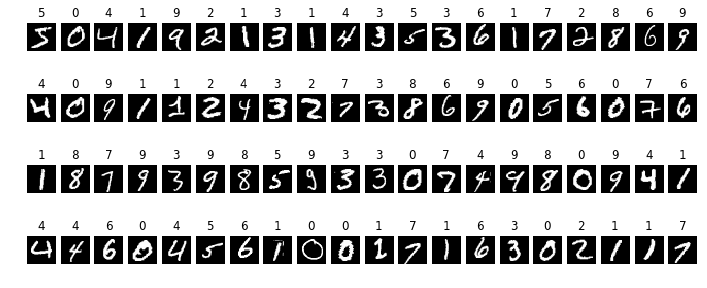

In [3]:
ROWS, COLS = 4, 20
f, axes = plt.subplots(ROWS, COLS, figsize=(12,5)) # image size is in inches
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        axes[i, j].imshow(train_images[index].reshape(28, 28), cmap='gray')
        axes[i, j].set_title(f"{train_labels[index].argmax()}")
        axes[i, j].axis('off')

### Define Graph

In [4]:
LEARNING_RATE = 0.1

tf.reset_default_graph() # not sure this is required

def variable_summaries(var):
    """Attach useful stats to `var`, typically a weight or bias variable."""
    with tf.name_scope('Summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('min', tf.reduce_min(var))    
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.histogram('histogram', var)
            
with tf.name_scope('Inputs'):
    x = tf.placeholder(tf.float32, shape=[None, 784], name='image') # Nx784
    y = tf.placeholder(tf.float32, shape=[None, 10], name='label')  # Nx10
with tf.name_scope('Layer1'):
    with tf.name_scope('Weights'):
        W = tf.Variable(tf.zeros([784, 10]), name='weights')  # 784x10
        variable_summaries(W)
    with tf.name_scope('Bias'):
        b = tf.Variable(tf.zeros([10]), name='bias') # 1x10
        variable_summaries(b)
    with tf.name_scope('Output'):
        y_hat = tf.identity(tf.matmul(x, W) + b, 'pre-activation') # Nx10
        variable_summaries(y_hat)

with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_hat, name='softmax'))
    tf.summary.scalar('crossentropy', loss)
with tf.name_scope('Optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE).minimize(loss)
with tf.name_scope('Performance'):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y,1), tf.argmax(y_hat,1)), tf.float32)) # % of correct predictions
    tf.summary.scalar('accuracy', accuracy);

summarize_all = tf.summary.merge_all()

### Train Network

In [5]:
NUM_ITERATIONS, BATCH_SIZE = 6000, 100 
SUMMARY_FREQ = 200
LOG_PATH = './TBLogs/'

def next_batch(batch_size, data, labels): 
    """Return an array of `batch_size` random samples and labels as a tuple."""
    indices = np.random.randint(low=0, high=data.shape[0], size=batch_size) # random indices of batch items
    return data[indices], labels[indices]

start_time = datetime.datetime.now()
init = tf.global_variables_initializer()
np.random.seed(42) 
with tf.Session() as sess:
    tbWriter = tf.summary.FileWriter(LOG_PATH + start_time.strftime("%Y%m%d-%H%M%S"), sess.graph)
    sess.run(init)    
    for i in range(NUM_ITERATIONS):        
        images, labels = next_batch(BATCH_SIZE, train_images, train_labels) # Nx784 and Nx10
        _, summary, l, acc = sess.run([optimizer, summarize_all, loss, accuracy], feed_dict={x:images, y:labels})
        tbWriter.add_summary(summary, i)
        if (i % SUMMARY_FREQ == 0) or (i == NUM_ITERATIONS-1):
#            l = sess.run(loss, feed_dict={x:images, y:labels})
            end_time = datetime.datetime.now()
#            acc = sess.run(accuracy, feed_dict={y:labels, x:images})
            print(f"Step {i} complete after {(end_time-start_time).total_seconds():.1f}s, with loss {l:.2f} and training accuracy {acc*100:.1f}%.")
    tbWriter.close()
    end_time = datetime.datetime.now()
    print(f"Elapsed time: {(end_time-start_time).total_seconds():.1f}s.")
    # Show accuracy on both data sets
    acc, weights, bias = sess.run([accuracy, W, b], feed_dict={x:train_images, y:train_labels})
    print(f"Accuracy on training data: {acc*100:.1f}%.")
    acc, weights, bias = sess.run([accuracy, W, b], feed_dict={x:test_images, y:test_labels})
    print(f"Accuracy on test data: {acc*100:.1f}%.")    


Step 0 complete after 0.3s, with loss 2.30 and training accuracy 7.0%.
Step 200 complete after 0.8s, with loss 0.59 and training accuracy 83.0%.
Step 400 complete after 1.3s, with loss 0.47 and training accuracy 88.0%.
Step 600 complete after 1.8s, with loss 0.31 and training accuracy 92.0%.
Step 800 complete after 2.3s, with loss 0.25 and training accuracy 94.0%.
Step 1000 complete after 2.7s, with loss 0.35 and training accuracy 88.0%.
Step 1200 complete after 3.3s, with loss 0.26 and training accuracy 93.0%.
Step 1400 complete after 3.7s, with loss 0.40 and training accuracy 88.0%.
Step 1600 complete after 4.2s, with loss 0.38 and training accuracy 87.0%.
Step 1800 complete after 4.7s, with loss 0.36 and training accuracy 89.0%.
Step 2000 complete after 5.2s, with loss 0.34 and training accuracy 86.0%.
Step 2200 complete after 5.7s, with loss 0.28 and training accuracy 91.0%.
Step 2400 complete after 6.2s, with loss 0.54 and training accuracy 84.0%.
Step 2600 complete after 6.6s, wi

### Run Against Test Set

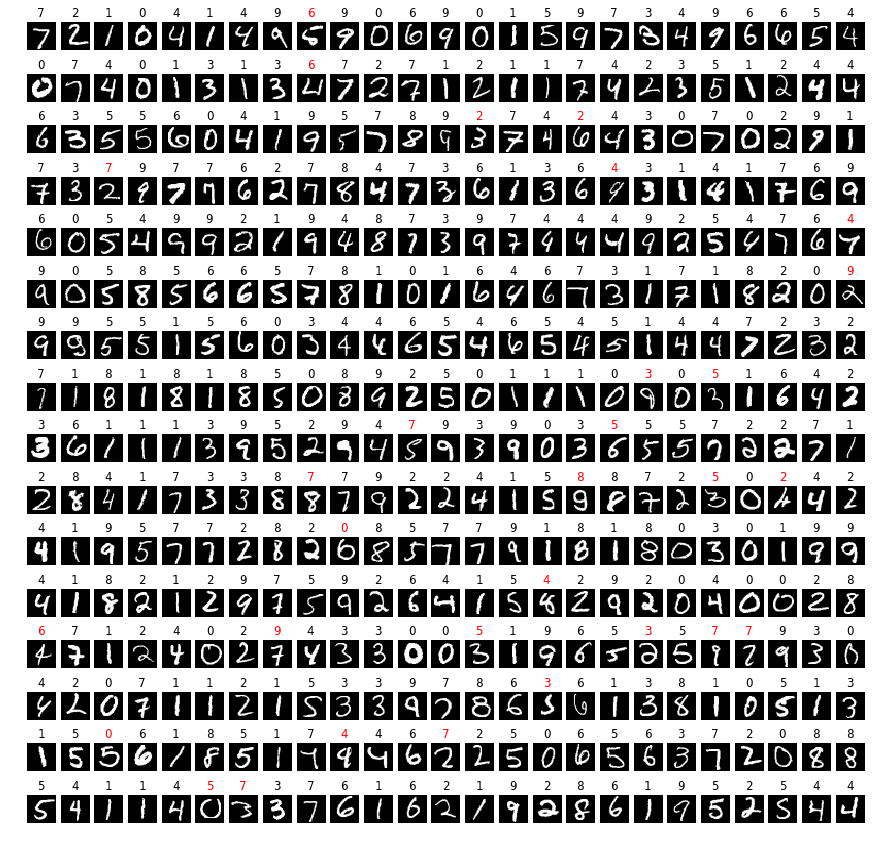

In [6]:
ROWS, COLS = 16, 25
np.set_printoptions(precision=3, suppress=True)
fig, axes = plt.subplots(ROWS, COLS, figsize=(15, 15)) # image size is in inches
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        output = np.matmul(test_images[index], weights) + bias # score = image * weights + bias
        probabilities = np.exp(output) / np.exp(output).sum() # activation fn converts scores to probalities
        color = 'k' if (probabilities.argmax() == test_labels[index].argmax()) else 'r'
        axes[i, j].imshow(test_images[index].reshape((28, 28)), cmap='gray')
        axes[i, j].set_title(f"{probabilities.argmax()}", color=color)
        axes[i, j].axis('off')

### Show Prediction Errors

In [7]:
errors = 0
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        image = test_images[index]
        output = np.matmul(image, weights) + bias 
        probabilities = np.exp(output) / np.exp(output).sum() # activation fn converts scores to probabilities
        label = test_labels[index].argmax()
        if (probabilities.argmax() != label):
            print(f"#{index} is {label}, predicted {output.argmax()}. Probabilities =", probabilities)
            errors += 1
print(f"{errors} error(s) out of {ROWS*COLS} ({errors*100/ROWS/COLS:.1f}%).")

#8 is 5, predicted 6. Probabilities = [0.001 0.    0.001 0.    0.003 0.002 0.992 0.    0.001 0.   ]
#33 is 4, predicted 6. Probabilities = [0.274 0.    0.015 0.    0.031 0.153 0.521 0.    0.006 0.   ]
#63 is 3, predicted 2. Probabilities = [0.    0.001 0.69  0.263 0.    0.001 0.001 0.    0.039 0.004]
#66 is 6, predicted 2. Probabilities = [0.003 0.005 0.284 0.114 0.049 0.005 0.249 0.27  0.017 0.005]
#77 is 2, predicted 7. Probabilities = [0.001 0.002 0.39  0.004 0.002 0.01  0.005 0.527 0.008 0.051]
#92 is 9, predicted 4. Probabilities = [0.001 0.006 0.024 0.018 0.473 0.039 0.011 0.027 0.076 0.325]
#124 is 7, predicted 4. Probabilities = [0.    0.    0.    0.    0.684 0.    0.    0.128 0.012 0.176]
#149 is 2, predicted 9. Probabilities = [0.    0.025 0.007 0.028 0.064 0.012 0.02  0.003 0.049 0.793]
#193 is 9, predicted 3. Probabilities = [0.    0.    0.004 0.3   0.29  0.016 0.002 0.072 0.03  0.286]
#195 is 3, predicted 5. Probabilities = [0.    0.025 0.077 0.23  0.009 0.397 0.019 0.001 

### Display Weights

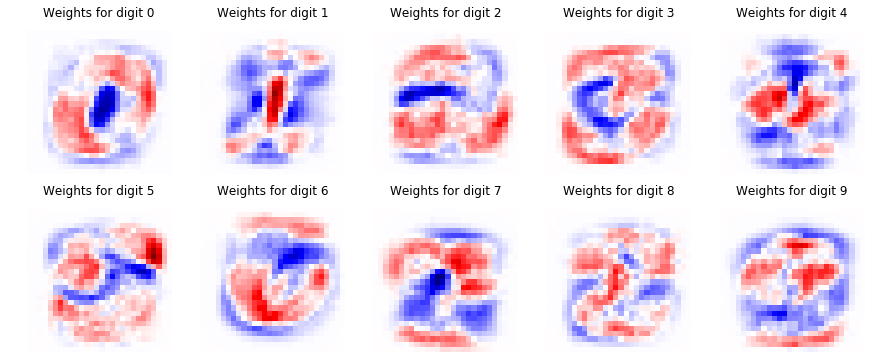

In [8]:
ROWS, COLS = 2, 5
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(15, 6)) # image size is in inches
abs_max = max(abs(weights.min()), abs(weights.max()))
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        w = weights[:, index].reshape(28,28)
        img = axes[i, j].matshow(w, cmap='seismic', vmin=-abs_max, vmax=abs_max)
        # plt.colorbar(img, ax=axes[i, j])
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Weights for digit {index}')

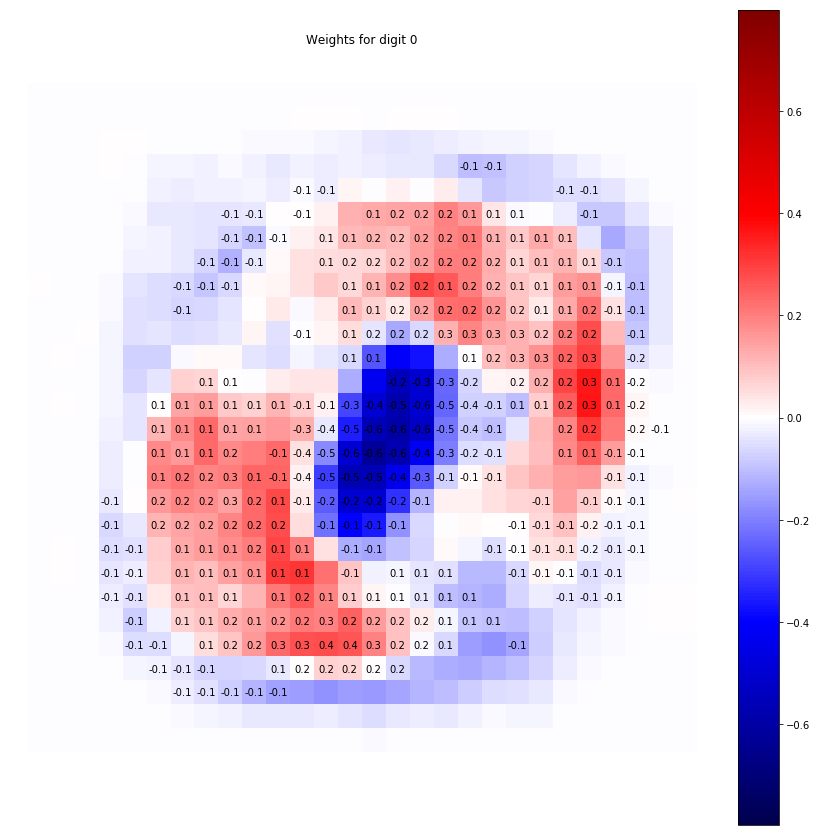

In [9]:
index = 0
w = weights[:, index].reshape(28,28)
fig, ax = plt.subplots(figsize=(15, 15))
for i in range(28):
    for j in range(28):
        if (abs(w[i, j]) > 0.05):
            ax.text(i, j, f'{w[i, j]:.1f}', va='center', ha='center')
img = ax.matshow(w, cmap='seismic', vmin=-abs_max, vmax=abs_max)
ax.set_title(f'Weights for digit {index}')
plt.colorbar(img)
ax.axis('off');

# Keras Implementation

### Define and Train Model

In [10]:
model = tf.keras.Sequential()
layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax, input_shape=(784,)) # Dense layer of 10 units
model.add(layer)
sgd = tf.keras.optimizers.SGD(lr=0.5, decay=0)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [11]:
np.random.seed(42) # Attempt to make results reproducible
model.fit(train_images, train_labels, epochs=5, batch_size=BATCH_SIZE, shuffle=True);

Epoch 1/5
60000/60000 [==============================] - 2s 32us/step - loss: 0.3927 - acc: 0.8872
Epoch 2/5
60000/60000 [==============================] - 1s 20us/step - loss: 0.3065 - acc: 0.9130
Epoch 3/5
60000/60000 [==============================] - 1s 20us/step - loss: 0.2923 - acc: 0.9176
Epoch 4/5
60000/60000 [==============================] - 1s 20us/step - loss: 0.2840 - acc: 0.9204
Epoch 5/5
60000/60000 [==============================] - 1s 20us/step - loss: 0.2789 - acc: 0.9216


### Show Output Summary

In [12]:
scores = model.predict(train_images)
check = np.equal(scores.argmax(axis=1), train_labels.argmax(axis=1))
print(f"Accuracy on training data = {100*check.sum()/check.shape[0]}%")
scores = model.predict(test_images)
check = np.equal(scores.argmax(axis=1), test_labels.argmax(axis=1))
print(f"Accuracy on test data = {100*check.sum()/check.shape[0]}%")

Accuracy on training data = 92.38833333333334%
Accuracy on test data = 92.4%


Accuracy on test data = 93.0%


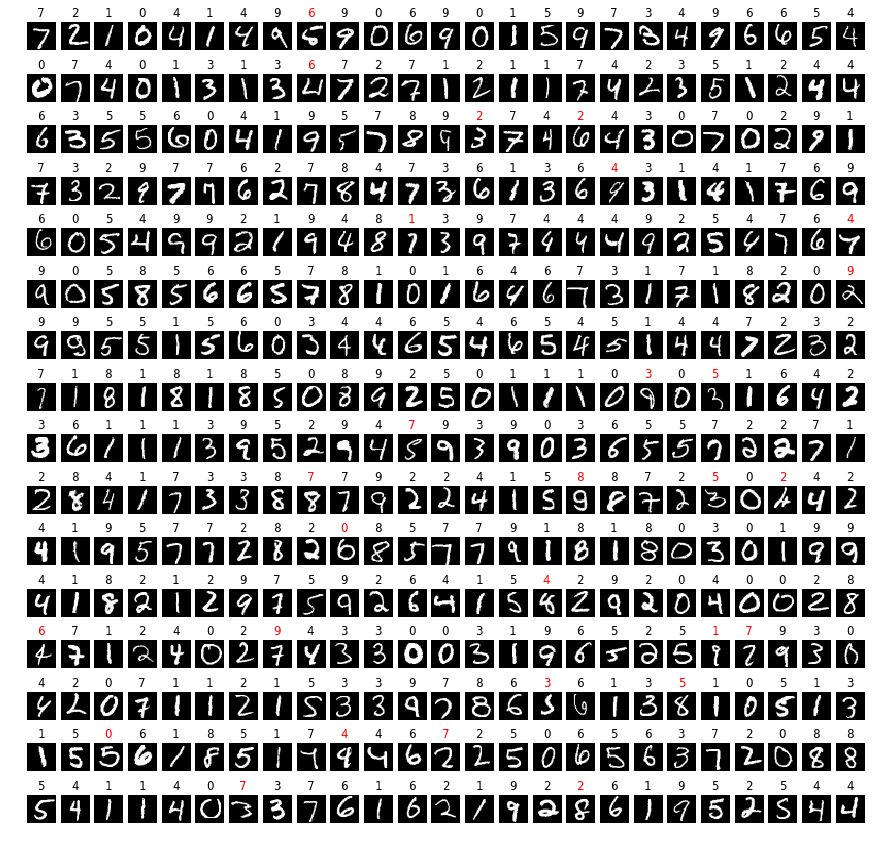

In [14]:
ROWS, COLS = 16, 25
scores = model.predict(test_images[0:ROWS*COLS])
check = np.equal(scores.argmax(axis=1), test_labels[0:ROWS*COLS].argmax(axis=1))
print(f"Accuracy on test data = {100*check.sum()/check.shape[0]}%")
np.set_printoptions(precision=3, suppress=True)
fig, axes = plt.subplots(ROWS, COLS, figsize=(15, 15)) # image size is in inches
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        color = 'k' if (scores[index].argmax() == test_labels[index].argmax()) else 'r'
        axes[i, j].imshow(test_images[index].reshape((28, 28)), cmap='gray')
        axes[i, j].set_title(f"{scores[index].argmax()}", color=color)
        axes[i, j].axis('off')

### Show Prediction Errors

In [15]:
errors = 0
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        image = test_images[index]
        label = test_labels[index].argmax()
        if (scores[index].argmax() != label):
            print(f"#{index} is {label}, predicted {scores[index].argmax()}. Probabilities =", scores[index])
            #print(scores[index])
            errors += 1
print(f"{errors} error(s) out of {ROWS*COLS} ({errors*100/ROWS/COLS:.1f}%).")

#8 is 5, predicted 6. Probabilities = [0.    0.    0.    0.    0.    0.001 0.998 0.    0.    0.   ]
#33 is 4, predicted 6. Probabilities = [0.337 0.    0.008 0.    0.035 0.059 0.558 0.    0.002 0.   ]
#63 is 3, predicted 2. Probabilities = [0.    0.    0.744 0.228 0.    0.    0.    0.    0.026 0.001]
#66 is 6, predicted 2. Probabilities = [0.001 0.002 0.373 0.054 0.066 0.002 0.228 0.267 0.006 0.001]
#92 is 9, predicted 4. Probabilities = [0.    0.004 0.017 0.014 0.593 0.032 0.008 0.02  0.035 0.277]
#111 is 7, predicted 1. Probabilities = [0.    0.555 0.017 0.023 0.    0.    0.    0.378 0.006 0.021]
#124 is 7, predicted 4. Probabilities = [0.    0.    0.    0.    0.83  0.    0.    0.119 0.004 0.047]
#149 is 2, predicted 9. Probabilities = [0.    0.01  0.005 0.009 0.047 0.007 0.012 0.001 0.01  0.899]
#193 is 9, predicted 3. Probabilities = [0.    0.    0.004 0.391 0.328 0.01  0.001 0.062 0.01  0.194]
#195 is 3, predicted 5. Probabilities = [0.    0.021 0.072 0.272 0.005 0.449 0.009 0.   

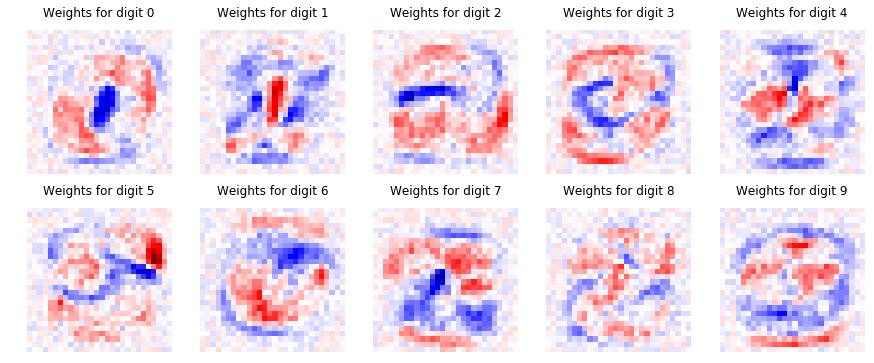

In [16]:
weights = layer.get_weights()[0]
ROWS, COLS = 2, 5
fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(15, 6)) # image size is in inches
abs_max = max(abs(weights.min()), abs(weights.max()))
for i in range(ROWS):
    for j in range(COLS):
        index = i*COLS + j
        w = weights[:, index].reshape(28,28)
        img = axes[i, j].matshow(w, cmap='seismic', vmin=-abs_max, vmax=abs_max)
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Weights for digit {index}')